In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.dpi'] = 125
plt.rcParams['figure.facecolor'] = 'white'

import numpy as np

import obspy
from obspy import read, UTCDateTime, Stream, Trace

import xarray as xr
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.signal import spectrogram as sp
from scipy.signal import welch 

import os
import sys  
module_path = os.path.abspath(os.path.join('/Users/gilaverbuch/dev/WavePropagation/pypekeris'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.pypekeris.pypekeris import pekeris, pekeris_broadband

# import webbrowser 
# import dask
# from dask import delayed, compute
# from dask.distributed import Client, LocalCluster


# cluster = LocalCluster(n_workers=3, threads_per_worker=2)
# client_dask = Client(cluster)
# webbrowser.open(client_dask.dashboard_link, new=2)

# Problem geometry

Two-layer liquid half space. Layer 1 (0<z<D) has a speed of sound c1. Layer 2 (z>D) has a speed of sound c2. Both source and receiver ar placed within the first layer. c2>c1. 

--------------------------------------------------------------------------------- z=0, pressure release surface

c1


*(0, z_s)




                                                           *(r,z)

--------------------------------------------------------------------------------- z=D, continuitu of P and w

c2

In [2]:
P = pekeris()
P._calc_parameters()
P._print_parameters()

zs 10
zr 10
r 5000
dr 10
c0 1500
c1 1500
c2 2000
d 50
dz 1
freq 50
nq 1000.0
omega 314.1592653589793
k0 0.20943951023931956
k1 1.0
k2 0.75
dq 0.00025


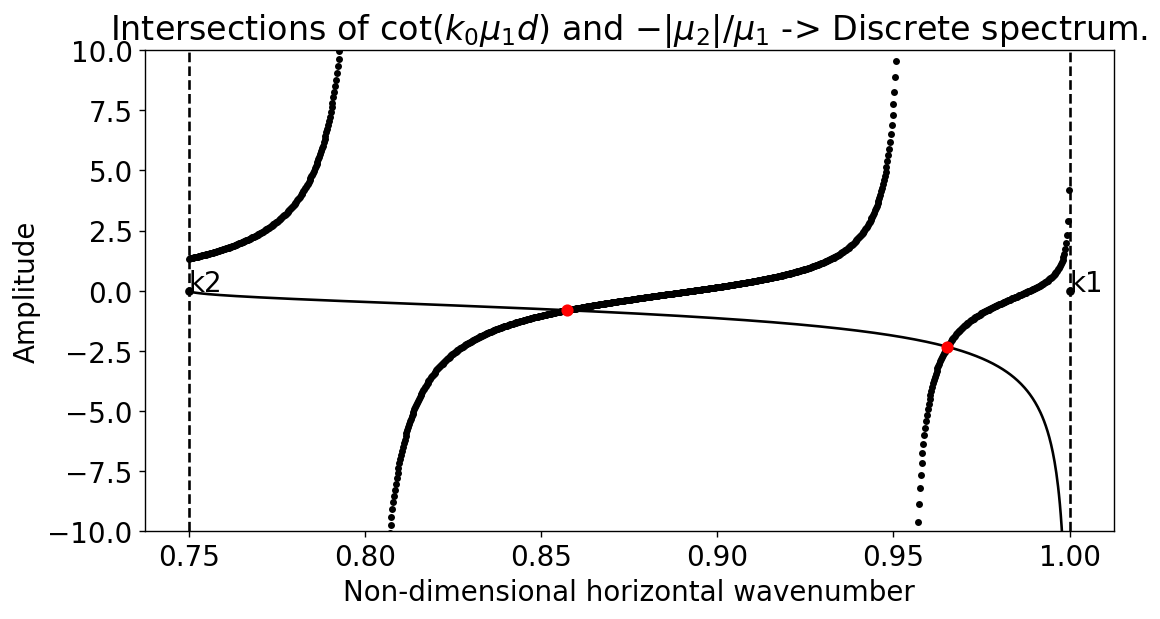

In [3]:
P._plot_discrete_modes()

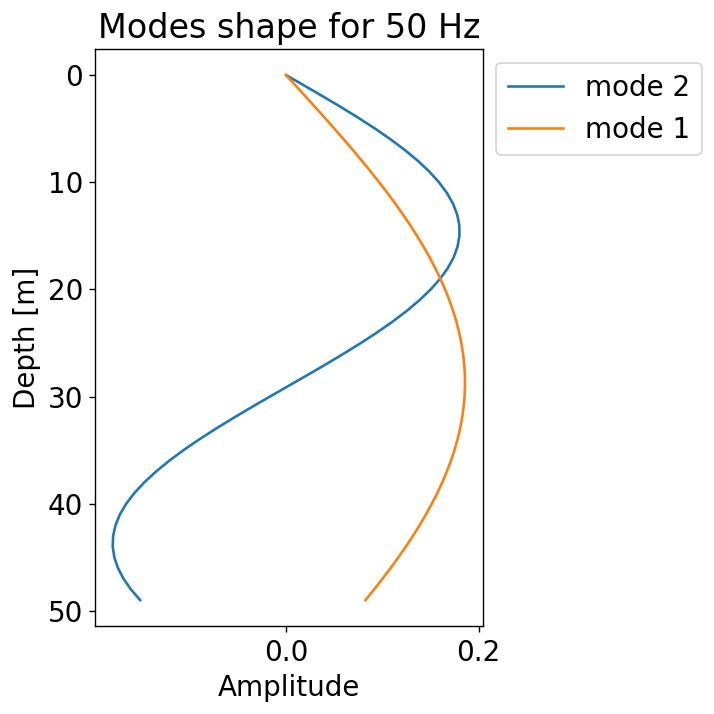

In [4]:
P._plot_modes_shape()

/Users/gilaverbuch/dev/WavePropagation/pypekeris/src/pypekeris/core/core.py:222: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(self._r, self._z, 20*np.log10(np.abs(self.Phi_2D)/np.abs(p_ref)))


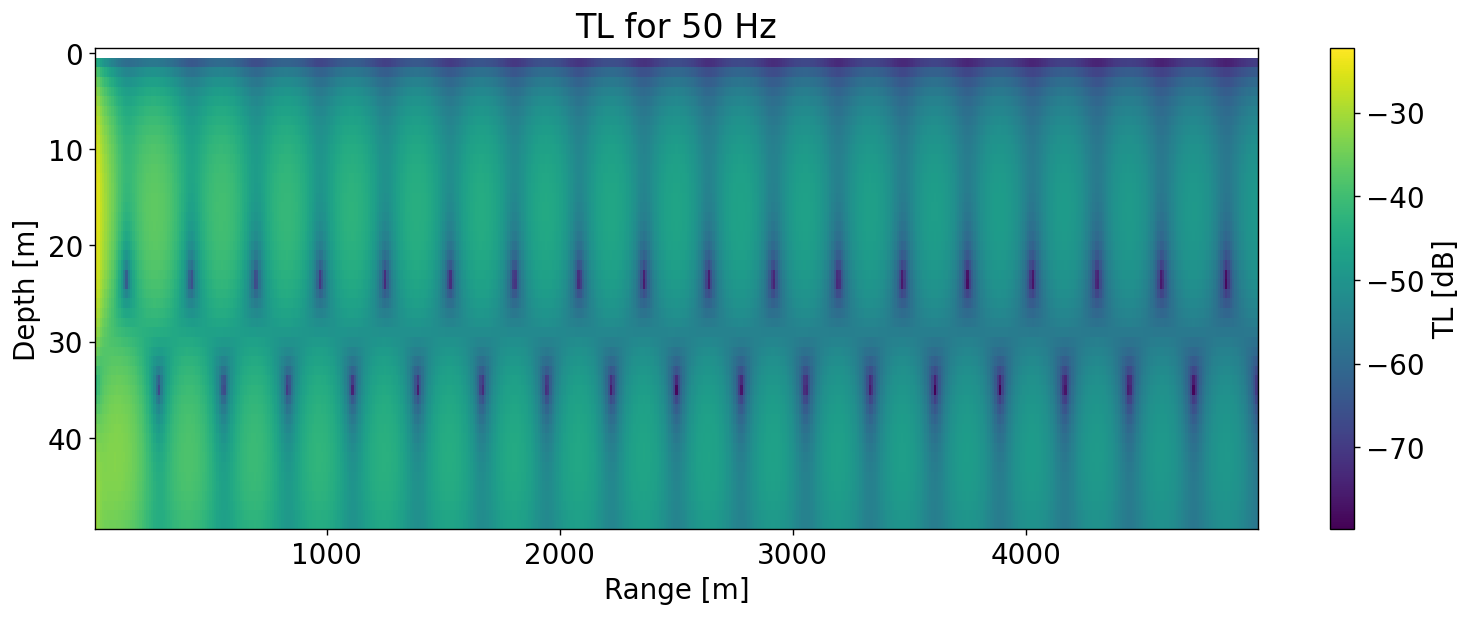

In [5]:
P._calc_2D_field()
P._plot_TL()

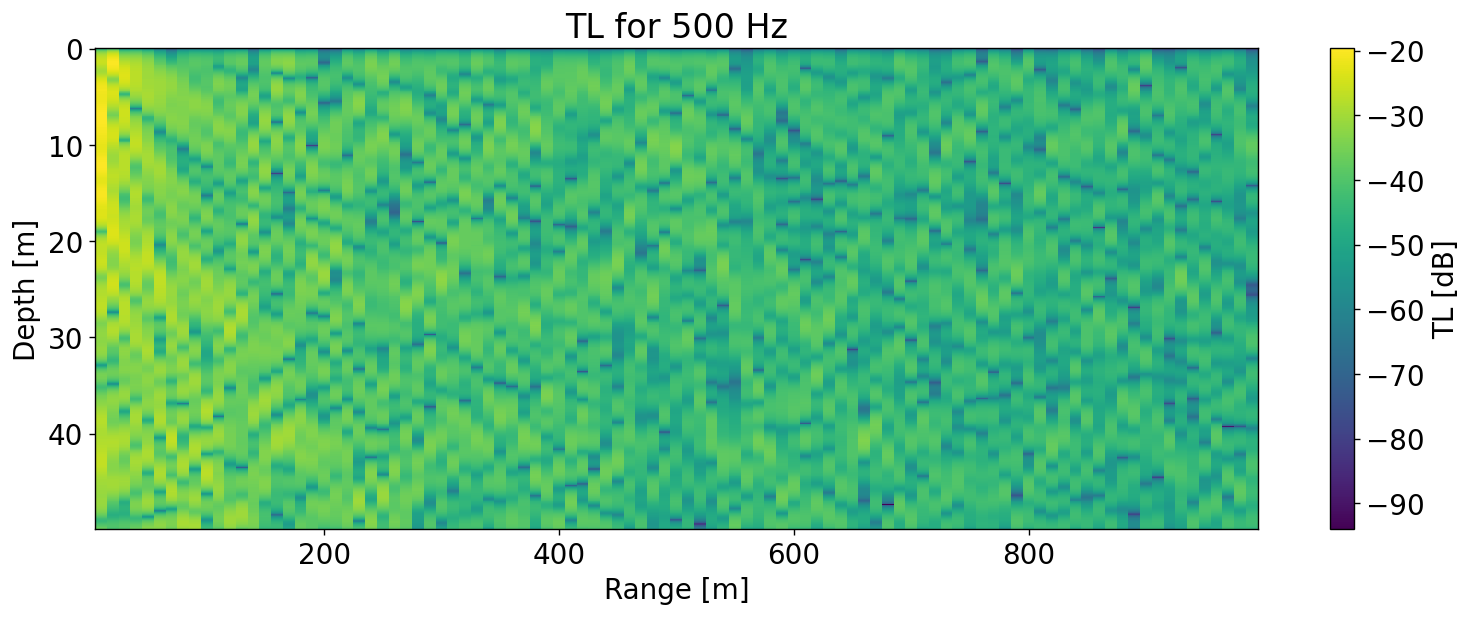

In [6]:
P.freq = 500
P.dz = 0.1
P.r = 1000
P._calc_parameters()
P._calc_2D_field()
P._plot_TL()

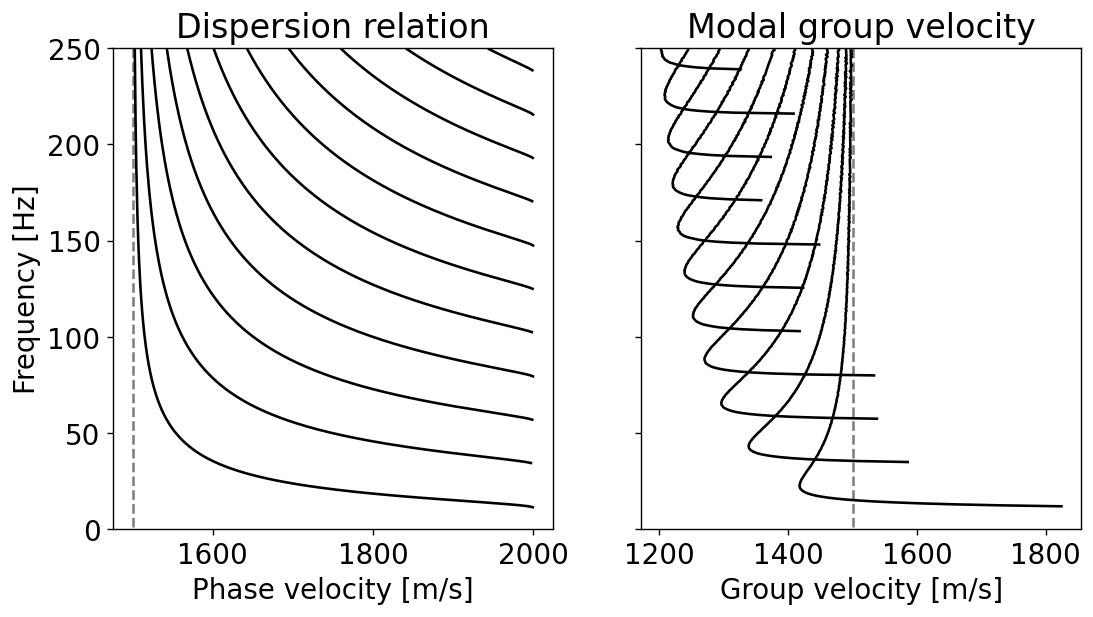

In [7]:
P.nq=5e4
P._calc_parameters()
P._plot_dispersion(fmax=250, df=0.1)

In [8]:
tr_s, tr_r = pekeris_broadband(fmax=3e2, r=2e4)

100%|███████████████████████████████████| 24999/24999 [00:17<00:00, 1468.71it/s]


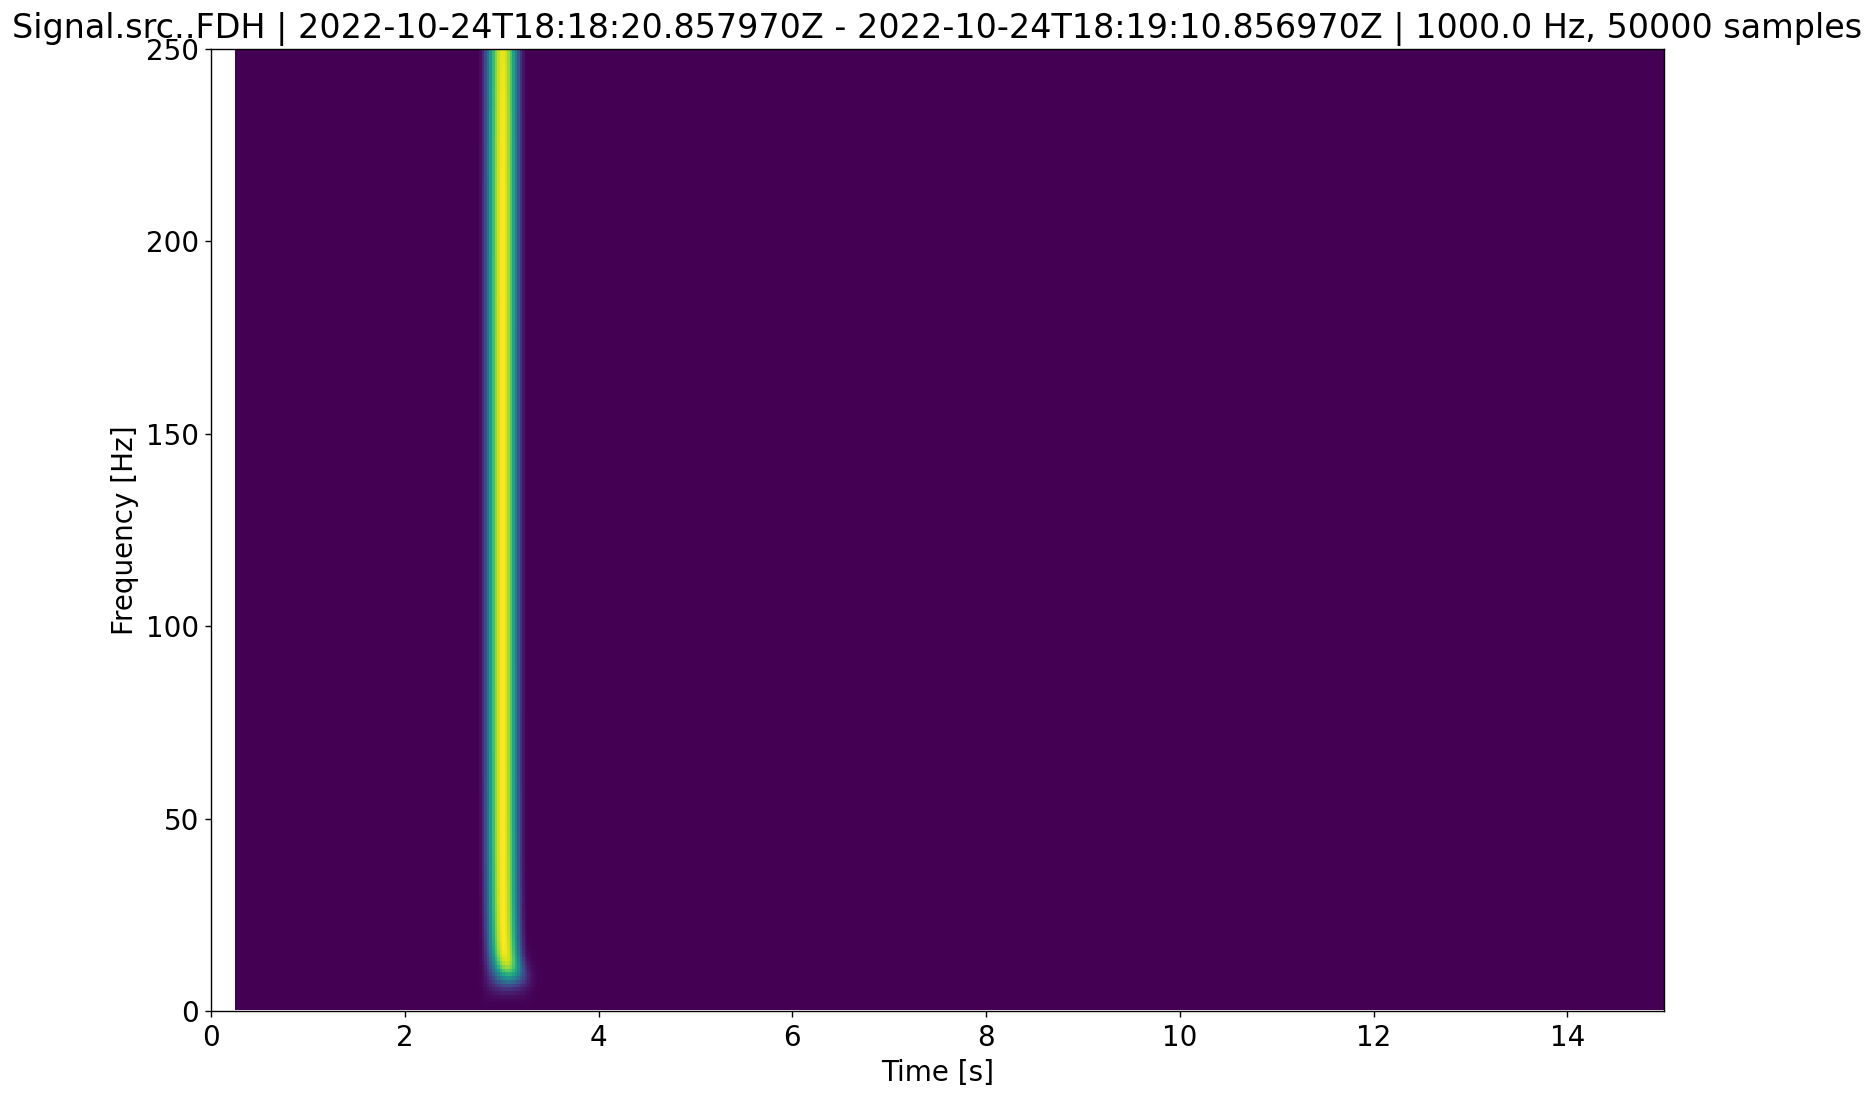

In [9]:
fig = tr_s.spectrogram(wlen=0.5, per_lap=0.95, mult=2, log=False, dbscale=False, show=False);
fig.set_figheight(10)
fig.set_figwidth(15)
plt.ylim(0,250)
plt.xlim(0,15)
plt.show()

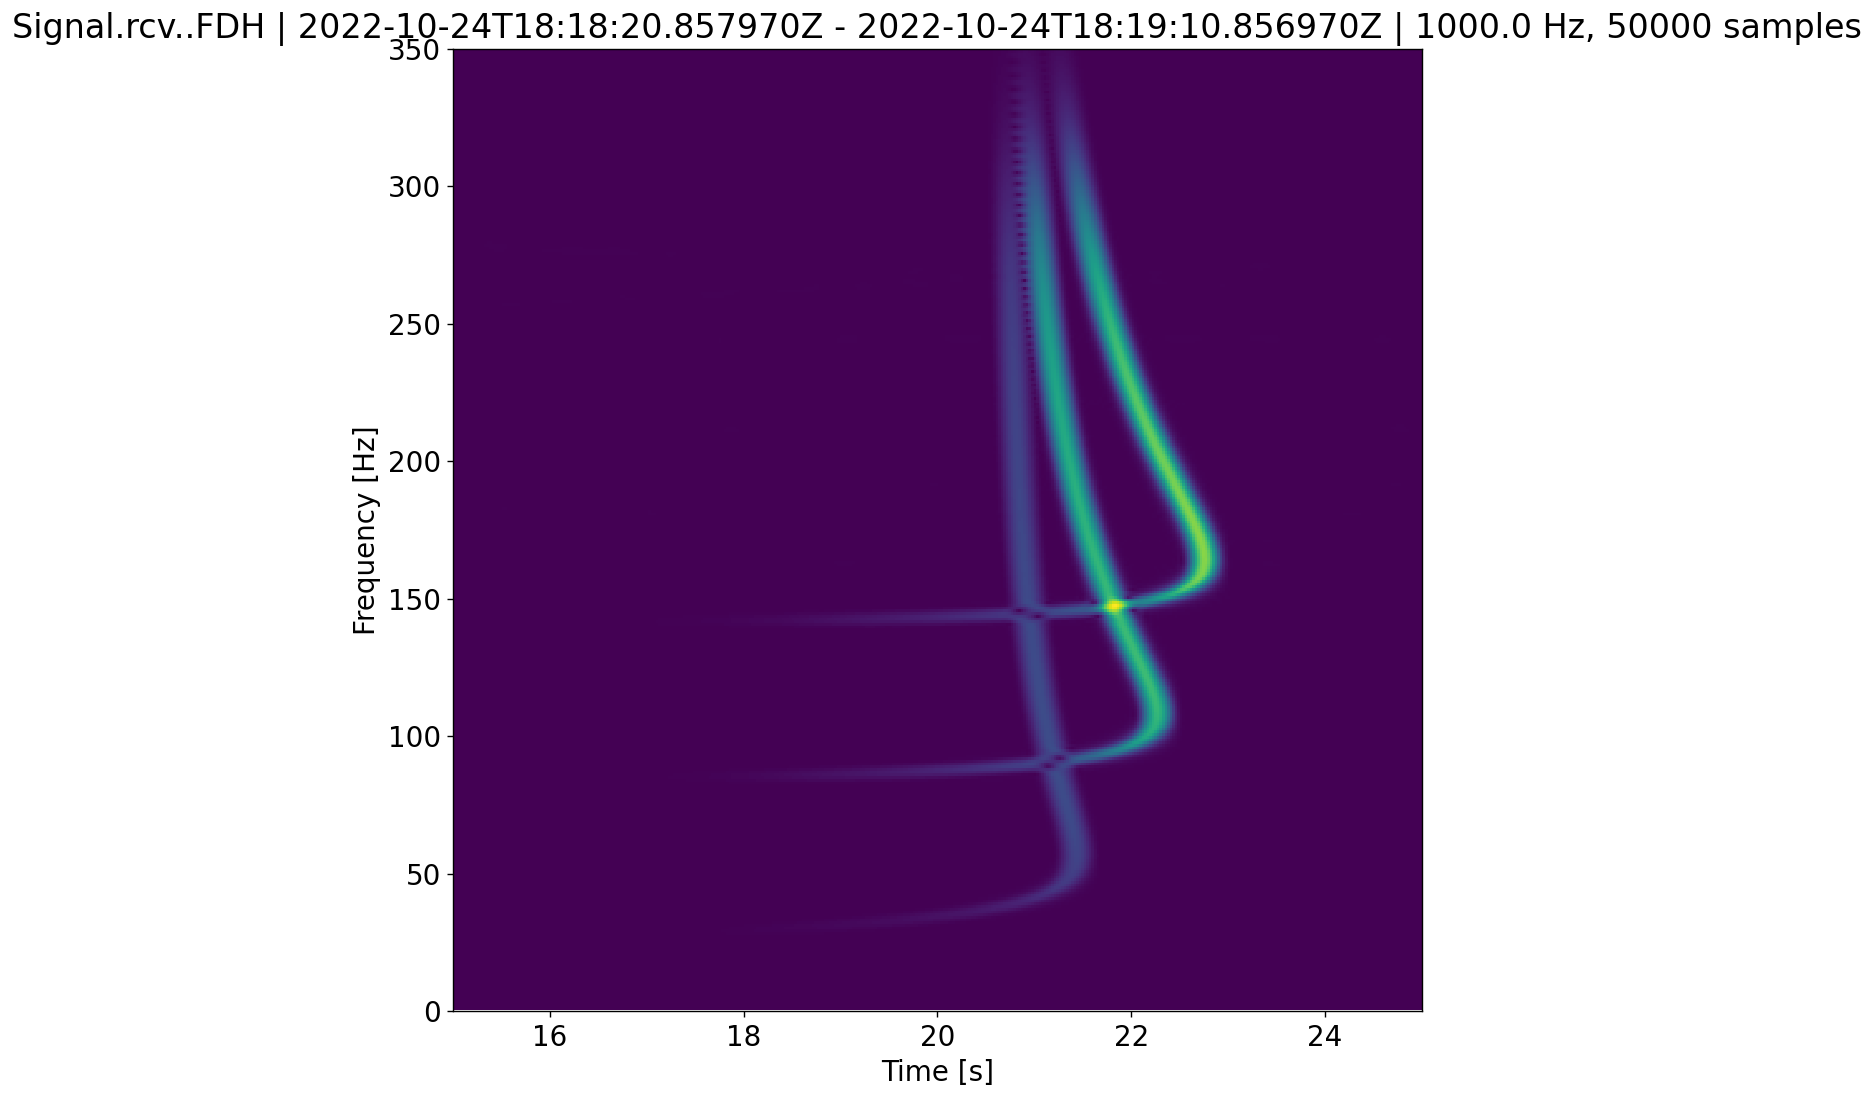

In [10]:
fig = tr_r.spectrogram(wlen=0.5, per_lap=0.95, mult=2, log=False, dbscale=False, show=False);
fig.set_figheight(10)
fig.set_figwidth(10)
plt.ylim(0,350)
plt.xlim(15,25)
plt.show()

# $\downarrow$ parallel broadband computation (still not working well) $\downarrow$

In [ ]:
def pekeris_broadband(t0=3, t_max=50, fmin=1e1, fmax=1e2, dt=1e-3, zs=5, zr=5, r=1e4, d=20, num_mode=3):
    '''
    This function is based on the Pekeris class, and conputes the broadband signal in a Pekeris waveguide.
    
    parameters
    ----------
        t0 = time delay of the signal, default is 3 sec
        t_max = maximum simulation time, default is 50 sec 
        fmin = minimum frequency, default is 1e1 Hz 
        fmax = maximum frequency, default is 1e2 Hz 
        dt = time intevals, default is 1e-3 sec 
        zs = source depth, default is 5 m 
        zr = receiver depth, default is 5 m 
        r = receiver distance, default is 1e4 m
        d = waveguide depth, default is 20 m
        num_mode = number of modes to compute, default is 3
    '''
    
    l=int(t_max/dt)
    time = np.arange(0,dt*l, dt)

    t0_samp = int(t0/dt)

    sig_ref = np.zeros(time.size, dtype=np.float32)
    sig_ref[t0_samp] = 1

    tr_s = Trace()
    tr_s.stats.network = 'Signal'
    tr_s.stats.station = 'src'
    tr_s.stats.channel = 'FDH' # 
    tr_s.stats.starttime = UTCDateTime.now()
    tr_s.stats.sampling_rate = 1/dt
    tr_s.stats.delta = dt
    tr_s.stats.npts = time.size
    tr_s.stats.calib = 1
    tr_s.stats.units = 'Norm.'
    tr_s.data = sig_ref

    tr_s.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4)

    sig_ref = tr_s.data/np.max(tr_s.data)

    l = len(sig_ref)
    frequency = np.fft.fftfreq(l, dt)
    df = frequency[1]
    freq_ref = np.fft.fft(sig_ref)

    pressure = np.zeros(frequency.size, dtype=np.complex64)

    fmax_idx = int(frequency.size/2)
    for idx, f in enumerate(tqdm(frequency[1:fmax_idx])):
        P = pekeris(f=f, nq=5e4, dr=1, zs=1, d=20)
        P._calc_parameters()
        P._calc_field(r_rec=r, z_rec=zr, num_mode=num_mode)
        pressure[idx] = P.Phi*freq_ref[idx]
        
    pressure_time = np.real(np.fft.fft(freq_ref*pressure*2))
    T = r/P.c1
    shift_samp = int(T/dt)
    signal = np.roll(pressure_time, shift=shift_samp)
    
    tr_r = tr_s.copy()
    tr_r.stats.station = 'rcv'
    tr_r.data = signal

    
    return tr_s, tr_r

    

In [ ]:
pressure = np.zeros(frequency.size, dtype=np.complex64)

z_r = 9
r_r = 10000
fmax_idx = int(frequency.size/2)
for idx, f in enumerate(tqdm(frequency[1:fmax_idx])):
    P = pekeris(f=f, nq=5e4, dr=1, zs=1, d=20)
    P._calc_parameters()
    P._calc_field(r_rec=r_r, z_rec=z_r, num_mode=3)
    pressure[idx] = P.Phi*freq_ref[idx]



In [ ]:
pressure_time = np.real(np.fft.fft(freq_ref*pressure*2))

In [ ]:
T = r_r/P.c1
print(T)
shift_samp = int(T/dt)

signal = np.roll(pressure_time, shift=shift_samp)
signal = signal/np.max(signal)
plt.figure()
plt.plot(time, signal)
plt.xlim(15,25)
plt.show()

In [ ]:
tr = Trace()
tr.stats.network = 'Signal'
tr.stats.station = '00'
tr.stats.channel = 'FDH' # 
tr.stats.starttime = UTCDateTime.now()
tr.stats.sampling_rate = 1/time[1]
tr.stats.delta = time[1]
tr.stats.npts = time.size
tr.stats.calib = 1
tr.stats.units = 'Norm.'
tr.data = signal #(signal/np.max(signal))

trc = tr.copy()
# tr.plot();
# trc.plot();

In [ ]:
trc.plot();

In [ ]:
import webbrowser 
import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster


cluster = LocalCluster(n_workers=3, threads_per_worker=2)
client_dask = Client(cluster)
webbrowser.open(client_dask.dashboard_link, new=2)

In [ ]:

def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

data = np.arange(0,5000,1)

output = []
for x in data:
    a = delayed(inc)(x)
    b = delayed(double)(x)
    c = delayed(add)(a, b)
    output.append(c)

total = delayed(sum)(output)

In [ ]:
total.compute()

In [ ]:
class calc():
    def __init__(self,x):
        self.x = x
        
    def inc(self):
        self.x = self.x + 1

    def double(self):
        self.y = self.x * 2

    def add(self):
        self.z = self.x + self.y
    
    def calc_all(self):
        self.inc()
        self.double()
        self.add()
        
        return self.z
        

data = np.arange(0,5000,1)

output = []
for x in data:
    a = calc(x)
    c = delayed(a.calc_all())
#     a = delayed(inc)(x)
#     b = delayed(double)(x)
#     c = delayed(add)(a, b)
    output.append(c)

# total = delayed(sum)(output)
total = compute(*output)

In [ ]:
np.sum(total)

In [ ]:
total.compute()

In [ ]:
37497500, 37507500

In [ ]:
dt = 1e-3
l=int(50/dt)
time = np.arange(0,dt*l, dt)

fmin = 10
fmax = 300

t0 = 3
t0_samp = int(t0/dt)

sig_ref = np.zeros(time.size, dtype=np.float32)
sig_ref[t0_samp] = 1

tr = Trace()
tr.stats.network = 'Signal'
tr.stats.station = 'src'
tr.stats.channel = 'FDH' # 
tr.stats.starttime = UTCDateTime.now()
tr.stats.sampling_rate = 1/dt
tr.stats.delta = dt
tr.stats.npts = time.size
tr.stats.calib = 1
tr.stats.units = 'Norm.'
tr.data = sig_ref

tr.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4)

sig_ref = tr.data/np.max(tr.data)

l = len(sig_ref)
frequency = np.fft.fftfreq(l, dt)
df = frequency[1]
freq_ref = np.fft.fft(sig_ref)

plt.figure(figsize=(15,5))
plt.plot(time, sig_ref)
plt.xlim(0,10)
plt.title('Signal')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(frequency, np.abs(freq_ref))
plt.xlim(0,500)
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
def _pekeris_broadband(f, freq_ref):
    z_r = 9
    r_r = 20000
    P = pekeris(f=f, nq=5e4, dr=1, zs=1, d=10)
    P._calc_parameters()
    P._calc_field(r_rec=r_r, z_rec=z_r, num_mode=2)
    
    return P


l =[]

pressure = np.zeros(frequency.size, dtype=np.complex64)
z_r = 9
r_r = 20000
fmax_idx = int(frequency.size/10)

for idx, f in enumerate(frequency):
    a = delayed(_pekeris_broadband)(f, freq_ref[idx]) 

    l.append(a)
p = compute(*l)    